In [1]:
suppressMessages(library("rwwa"))

# Checking & revising `norm_logt` functions (don't always work as expected)

## Check using revised & reinstalled package

In [8]:
tp <- read.csv("~/wwa/25-08_spain-fires/data/ts_tp-jja_era5_1950-2025.csv")

# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

df <- merge(gmst, tp)
df$tp <- df$tp * 92    # convert mean daily rate to sum
df$tplog <- log(df$tp)

mdl_norm <- fit_ns("norm", "fixeddisp", data = df, varnm = "tp", covnm = "gmst", lower = T)
mdl_normlog.shift <- fit_ns("norm", "shift", data = df, varnm = "tplog", covnm = "gmst", lower = T)
mdl_normlog.fd <- fit_ns("norm", "fixeddisp", data = df, varnm = "tplog", covnm = "gmst", lower = T)
mdl_normlogt <- fit_ns("norm_logt", "shift", data = df, varnm = "tp", covnm = "gmst", lower = T)  # model fitting does not fail when using accum ulated rainfall

In [9]:
aic(mdl_norm); aic(mdl_normlog.shift) + 2*sum(mdl_normlog.shift$x); aic(mdl_normlog.fd) + 2*sum(mdl_normlog.fd$x); aic(mdl_normlogt)

[1] 788.5849

[1] 777.0571

[1] 776.7827

[1] 777.0571

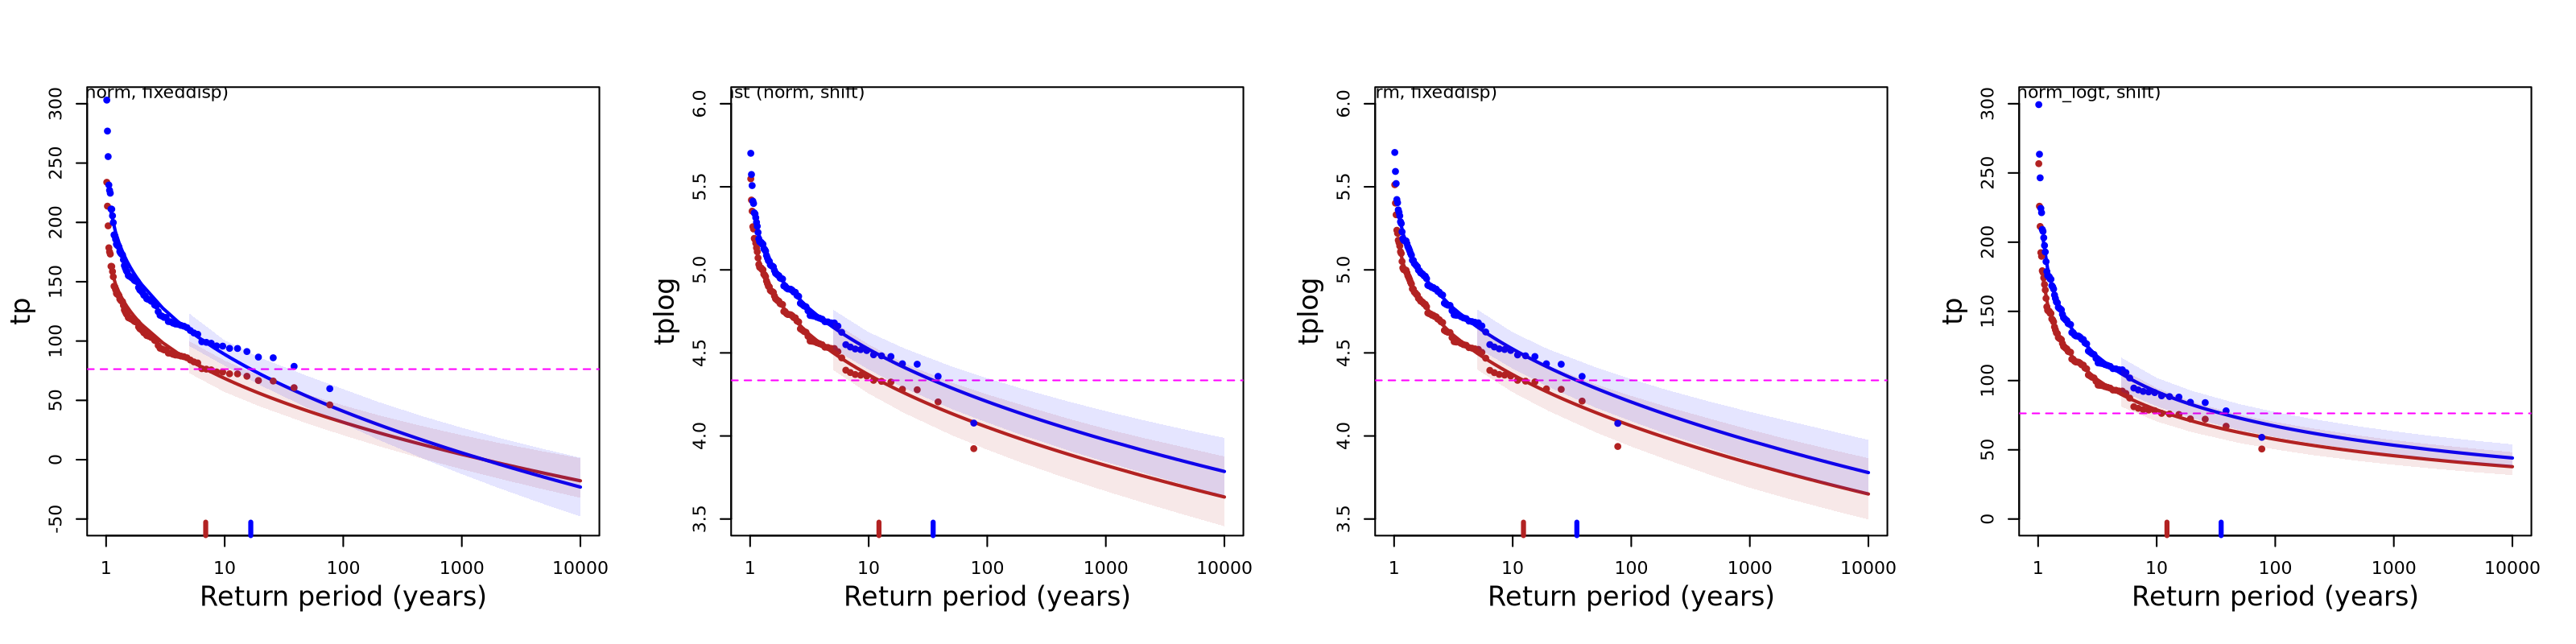

In [11]:
prep_window(c(1,4))
invisible(sapply(list(mdl_norm, mdl_normlog.shift, mdl_normlog.fd, mdl_normlogt), plot_returnlevels, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50))

---
# Working area

## Likelihood from logged data

The likelihood of logged data can be transformed to be comparable to likelihood of raw data by adding the sum of the log-transformed values to the likelihood:

In [2]:
set.seed(42)

x <- rnorm(1000) + 500
logx <- log(x)

In [3]:
# computed (adjusted) log-likelihood
-sum(dnorm(x, mean(x), sd(x), log = T))
sum(logx)-sum(dnorm(logx, mean(logx), sd(logx), log = T))

[1] 1420.957

[1] 1420.964

In [4]:
df <- data.frame(x = x, logx = logx, gmst = rep(1:1000))
df$x <- df$x + df$gmst + 500
df$logx <- log(df$x)

In [5]:
AIC(lm(x ~ gmst, df))
AIC(lm(logx ~ gmst, df)) + 2*sum(df$logx)

[1] 2847.807

[1] 9341.845

## summer temps from Greece fire study

Check results with summer temperatures, which are already pretty Gaussian (so expect same fit for raw & log-transformed data)

In [38]:
tp <- read.csv("~/wwa/25-08_spain-fires/data/ts_tp-jja_era5_1950-2025.csv")
t2m <- read.csv("~/wwa/25-08_spain-fires/data/ts_t2m-jja_era5_1950-2025.csv")

# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

df <- merge(merge(gmst, t2m), tp)
df$tpsum <- df$tp * 92
df$tplog <- log(df$tpsum)
df$t2mlog <- log(df$t2m)

[1] 185.6409

[1] 189.6873

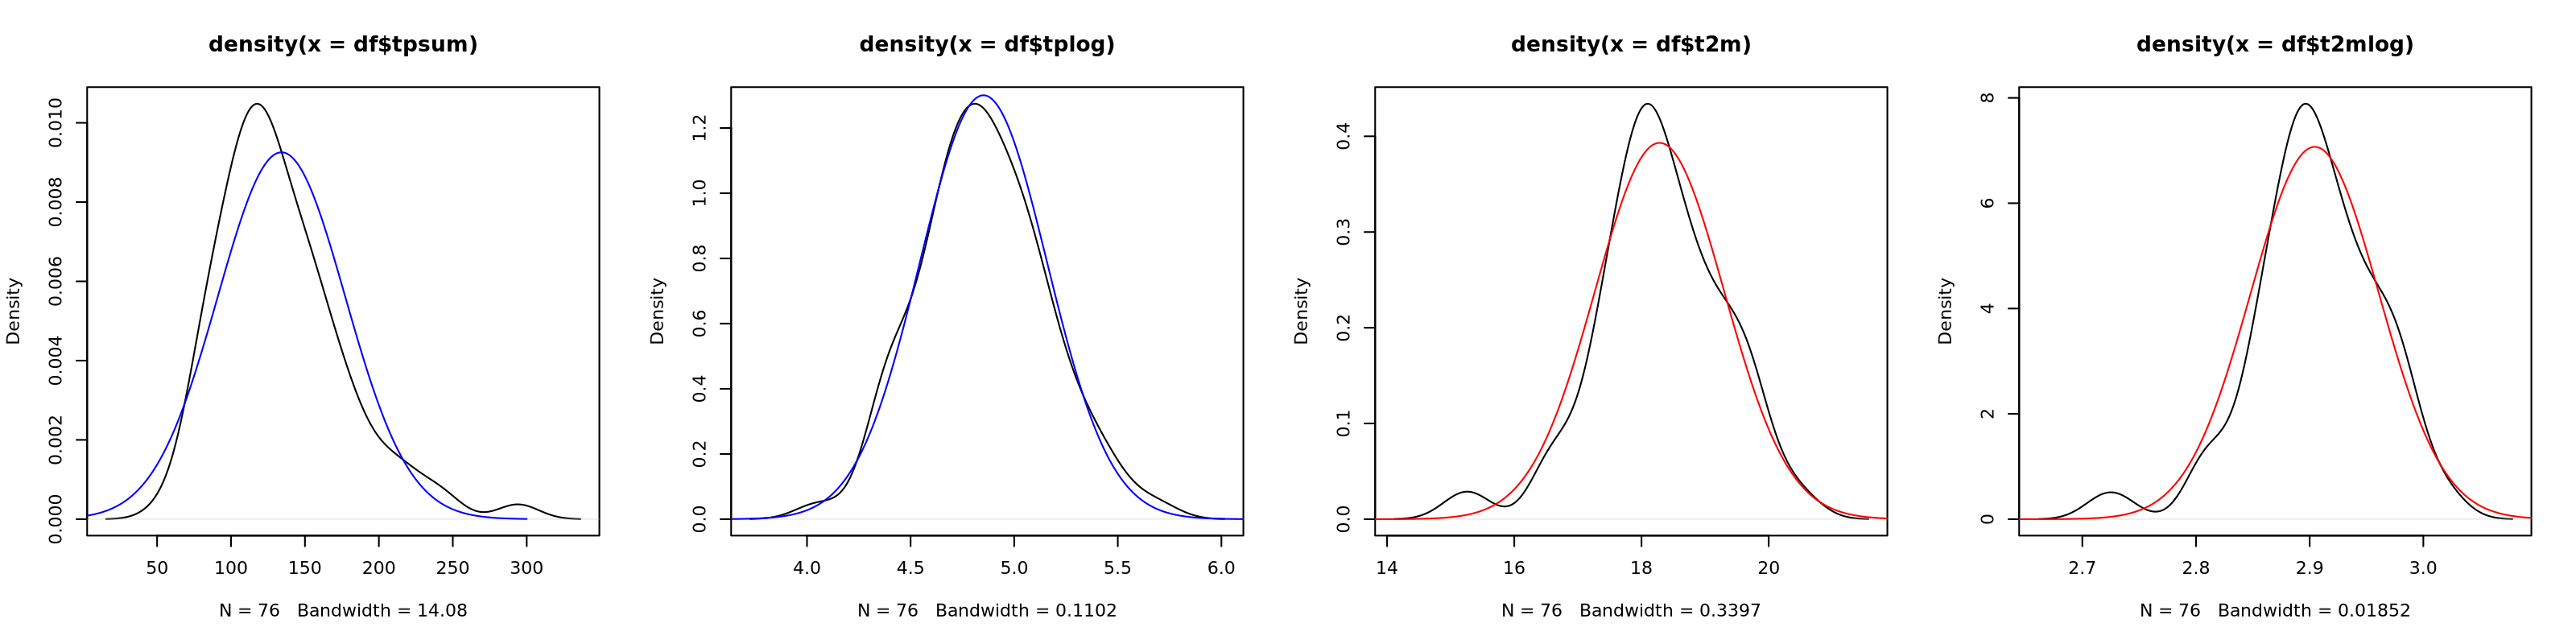

In [39]:
prep_window(c(1,4))

plot(density(df$tpsum)); lines(x <- seq(0,300,1), dnorm(x, mean(df$tpsum), sd(df$tpsum)), col = "blue")
plot(density(df$tplog)); lines(x <- seq(3,7,0.01), dnorm(x, mean(df$tplog), sd(df$tplog)), col = "blue")
plot(density(df$t2m)); lines(x <- seq(12,22,.01), dnorm(x, mean(df$t2m), sd(df$t2m)), col = "red")
plot(density(df$t2mlog)); lines(x <- seq(2,4,0.001), dnorm(x, mean(df$t2mlog), sd(df$t2mlog)), col = "red")

lm_norm <- lm(t2m ~ gmst, df)
lm_lnorm <- lm(t2mlog ~ gmst, df)

AIC(lm_norm)
AIC(lm_lnorm) + 2*sum(df$t2mlog)

In [34]:
mdl_norm <- fit_ns("norm", "shift", data = df, varnm = "tpsum", covnm = "gmst", lower = F)
mdl_normlog <- fit_ns("norm", "shift", data = df, varnm = "tplog", covnm = "gmst", lower = F)
mdl_normlogt <- fit_ns("norm_logt", "shift", data = df, varnm = "tpsum", covnm = "gmst", lower = F)  # model fitting does not fail in this case

aic(mdl_norm); aic(mdl_normlog) + 2*sum(mdl_normlog$x); aic(mdl_normlogt)

[1] 790.8666

[1] 777.0571

[1] 519.1149

## Incorrect return periods for norm_logt

In [35]:
1/map_to_u(mdl_normlogt, mdl_normlogt$ev, fixed_cov = cov_2024)

[1] 1.089192

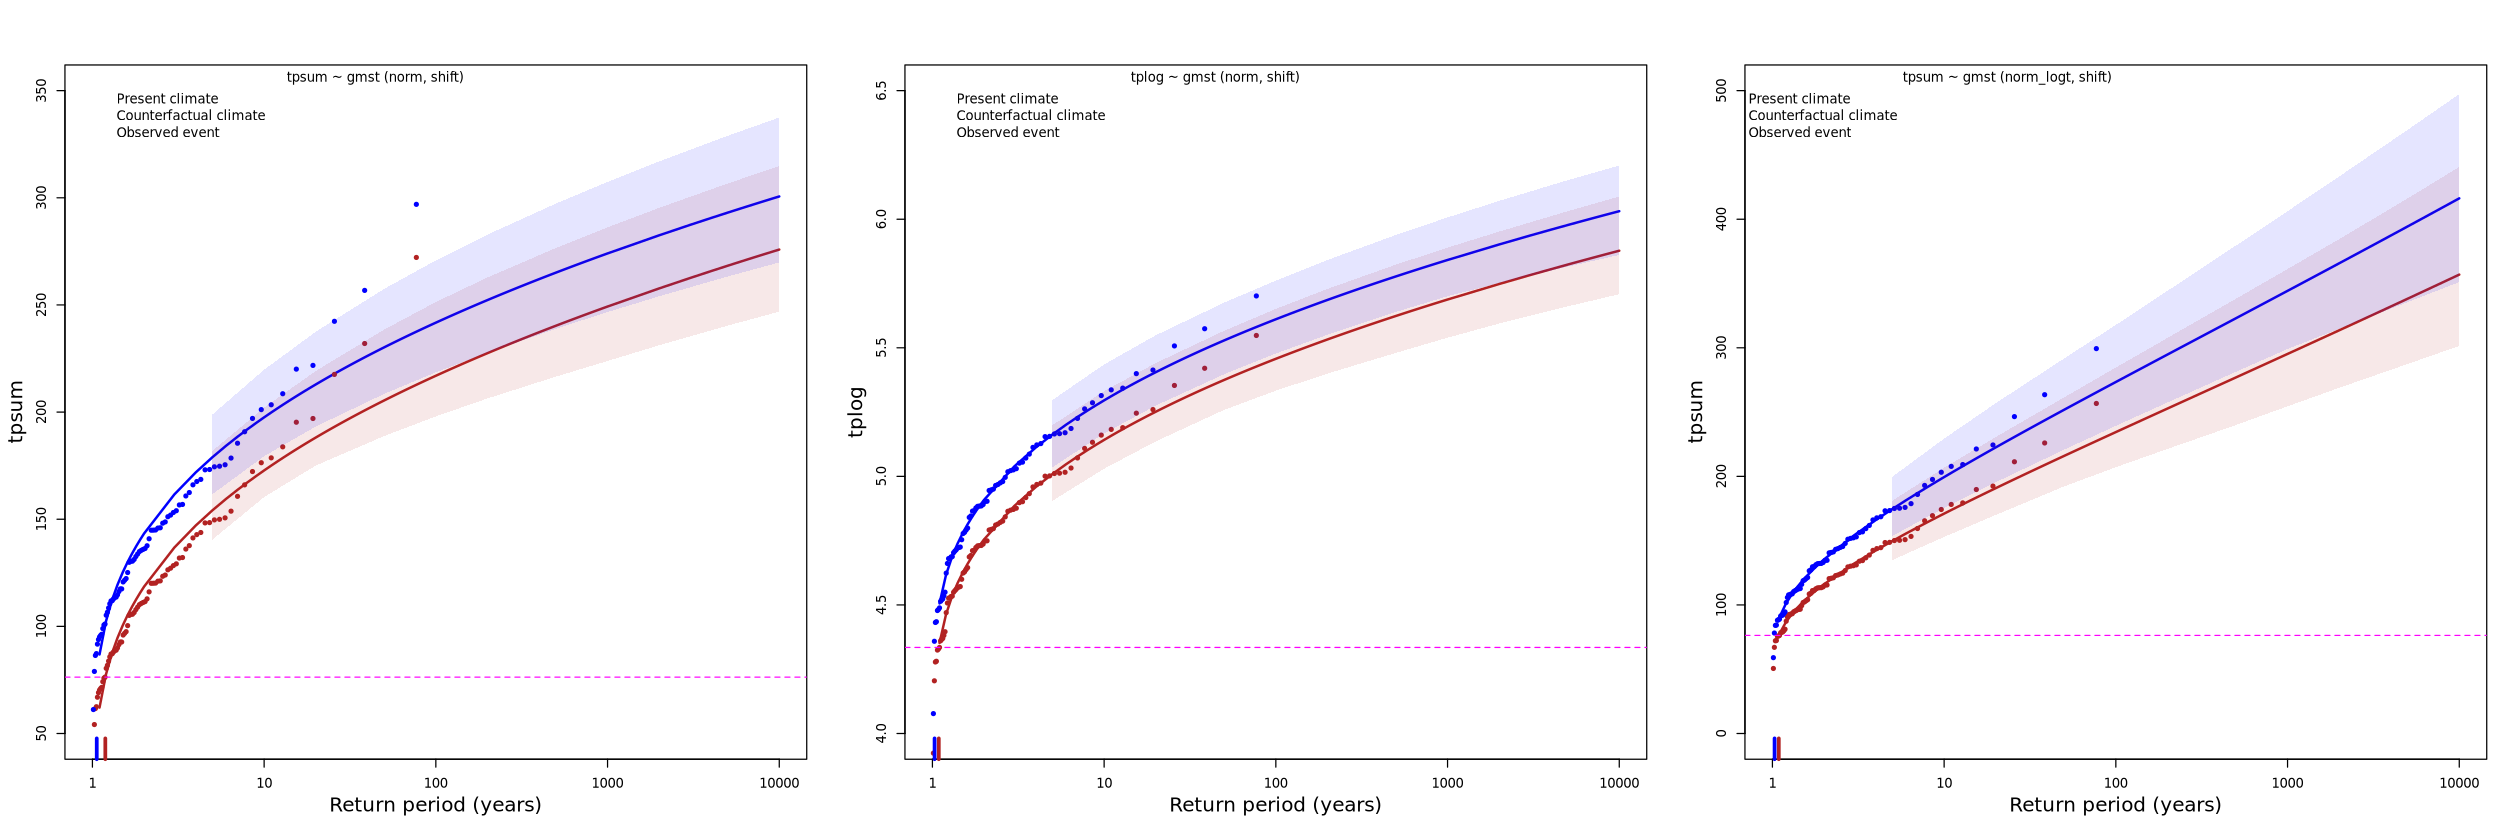

In [37]:
prep_window(c(1,3), h = 7, w = 7, res = 120)
plot_returnlevels(mdl_norm, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(mdl_normlog, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(mdl_normlogt, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)

In [28]:
plot_returnlevels <- function(mdl, cov_f, cov_cf, ev, seed = 42, nsamp = 500, model_desc = T,
                              xlim = c(1,10000), ylim = NA, pch = 20, xlab = "Return period (years)", ylab = NA, main = "",
                              legend_pos = "topright", legend_labels = c("Present climate", "Counterfactual climate")) {

  x <- mdl$x
  if(mdl$dist == "norm_logt") x <- exp(x)    # ADDED
  if(missing(ev)) { ev <- mdl$ev }

  rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
  rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

  # trim covariates if necessary
  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }
  # trim covariates if necessary
  if(nrow(cov_cf) > 1) {
    print("cov_cf has more than one row: only first row will be used as counterfactual covariates")
    cov_cf <- cov_cf[1,,drop = F]
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # calculate return periods & return levels

  rl_curve_pres <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_f)
  rl_curve_cf <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_cf)

  rl_obs_pres <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_f)
  rl_obs_cf <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_cf)

  rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov_f)
  rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)

  if (mdl$dist %in% c("norm_logt")) {
    rl_curve_pres <- exp(rl_curve_pres)
    rl_curve_cf <- exp(rl_curve_cf)
    rl_obs_pres <- exp(rl_obs_pres)
    rl_obs_cf <- exp(rl_obs_cf)
    # rp_event_pres <- exp(rp_event_pres)  # NO
    # rp_event_cf <- exp(rp_event_cf)      # NO
    ev <- exp(ev)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # prep axes

  if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
  if(is.na(ylab)) {ylab <- mdl$varnm}

  # plot
  plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
  mtext(xlab, side = 1, line = 2.5, cex = par("cex.lab"))
  mtext(ylab, side = 2, line = 2.5, cex = par("cex.lab"))

  # if model description is required, add it as legend title
  if(model_desc) {
    legend_title <- paste0(mdl$varnm, " ~ ", paste0(mdl$covnm, collapse = " + "), " (",mdl$dist, ", ", mdl$type, ")")
  } else {
    legend_title <- ""
  }

  # add legend
  legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA),
         bty = "n", cex = par()$cex.lab, title = legend_title)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  # return period curves
  lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
  lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual

  # expected return periods vs return levels transformed to stationarity at that covariate value
  points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
  points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual

  # horizontal line showing observed event, plus ticks showing return periods
  abline(h = ev, col = "magenta", lty = 2)
  suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
  suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # Add confidence intervals to return periods

  if(!is.na(nsamp)) {
    x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
    set.seed(seed)

    mdl_df <- mdl$data
    boot_res <- sapply(1:nsamp, function(i) {
      boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
      tryCatch({
        boot_mdl <- refit(mdl, boot_df)
        # print(boot_mdl$par)
        c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_f), map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
      }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
    })
    est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
    if (mdl$dist %in% c("norm_logt")) est_ci <- exp(est_ci)

    # shaded region for confidence intervals
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", 0.1))
  }
}